In [1]:
%matplotlib widget

import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display as ipd


# Import Tensorflow 2.0
import tensorflow as tf
from livelossplot import PlotLossesKeras

from time import sleep
from tqdm import tqdm

from ipycanvas import Canvas, RoughCanvas, hold_canvas

from scipy.stats import truncnorm

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print(gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
        
#!jupyter labextension list

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
class Env():
    
    def __init__(self, num_steps):
    
        self.num_steps = num_steps
        self.num_trees = 1
        self.num_fruits = 50
        self.reset()

    def reset(self):
        
        self.trees = [100]

        self.fruits = np.zeros((self.num_fruits, 3))
        fruits = []
        for xt in self.trees:
            fruits.extend(xt+np.round(20*truncnorm.rvs(-1, 1, size=int(self.num_fruits/self.num_trees))))
        self.fruits[:,0]=fruits
        self.fruits[:,1]=np.random.uniform(10,50,self.num_fruits)  #number of time steps before fruit's location changes
        self.fruits[:,2]=self.trees[0]
        #self.fruits[:int(self.num_fruits/2),2]=self.trees[0] #remember the tree where the next fruit will fall
        #self.fruits[int(self.num_fruits/2):,2]=self.trees[1]
        
        self.agent = random.randrange(50, 150)
        self.speed = -1 if random.randint(0,1) == 0 else 1
        
        self.countfruits = 0
        self.score = 0.
        self.timestep = 0
        
        return self.obs()

    def obs(self):
        o = [(self.agent-xt) for (xt) in self.trees]
        o.append(self.speed)
        return o
    
        
    def step(self, action):

        self.timestep += 1
        
        #replace old fruit
        self.fruits[:,1] -= 1 #age all fruits
        old = np.where(self.fruits[:,1]<=0, True, False) #find fruits with expired shelf life...
        self.fruits[:,0] = np.where(old, self.fruits[:,2]+np.round(20*truncnorm.rvs(-1,1)), self.fruits[:,0]) #drop a new fruit near the same tree
        self.fruits[:,1] = np.where(old, np.random.uniform(10,50), self.fruits[:,1]) #and give it a new shelf life

        #move the agent
        direction = -1 if action==0 else +1
        distance = direction #* random.randint(1,5)
        self.speed = direction
        self.agent += distance  #change the position
        
        #calculate the reward
        
        #self.score -= abs(distance)  #consume energy, negative reward, for moving
        
        found = np.where(self.agent==self.fruits[:,0], True, False)
        count = np.count_nonzero(found==True)
        self.score += 1000 * count #it is possible that several fruits have the same location
        self.countfruits += count
        if count>0:
            self.fruits[:,0] = np.where(found, self.fruits[:,2]+np.round(20*truncnorm.rvs(-1,1)), self.fruits[:,0]) #drop a new fruit near the same tree
            self.fruits[:,1] = np.where(found, np.random.uniform(10,50), self.fruits[:,1]) #and give it a new shelf life
        
        terminated = True if self.timestep>=self.num_steps else False
        if self.agent<=0 or self.agent>=200:
            terminated = True
            self.score += -100000 #discourage suicidal policies

        o = self.obs()
        reward = self.score
        
        return o, reward, terminated   

    
    def init_canvas(self):
        #canvas = Canvas(width=1000, height=200)
        self.canvas = RoughCanvas(width=500, height=200)
        self.canvas.font = "10px serif"
        display(self.canvas)        
        
        
    def update_canvas(self, sleeptime=0.02):
        #draw the scene
        with hold_canvas():
            # Clear the old animation step
            self.canvas.clear()

            y = 100
            size = 5

            self.canvas.stroke_text("time:%d"%self.timestep, 10, 10)
            #self.canvas.stroke_text("#fruits:%d"%len(self.fruits), 10, 30)
            self.canvas.stroke_text("#score:%d"%self.score, 10, 30)
            self.canvas.stroke_text("#found:%d"%self.countfruits, 10, 50)

            self.canvas.stroke_style = "blue"
            for (x) in self.trees:
                self.canvas.stroke_rect(x, y, size, size)

            self.canvas.fill_style = "red"
            xs = self.fruits[:,0]
            ys = [100]*self.num_fruits
            self.canvas.fill_circles(xs, ys, size) #use vectorized version

            self.canvas.stroke_style = "green"
            self.canvas.stroke_rect(self.agent, y, size, size)


        # Animation frequency ~50Hz = 1./50. seconds
        if sleeptime>0:
            sleep(sleeptime)


    def play(self, model):
        self.init_canvas()
        terminated=False
        obs = self.reset()
        res=[]
        while not terminated:
            action, logits = choose_action(model, obs, greedy=True)
            obs, reward, terminated = self.step(action)
            self.update_canvas(sleeptime=0)        
            res.append([obs,logits,action,reward])
        return res
            
e = Env(100)

e.init_canvas()
terminated=False
obs = e.reset()
while not terminated:
    
    #policy:
    xt = obs[0]
    if abs(xt)>20:
        action = 0 if xt>0 else 1 #go towards the nearest tree
    else:
        speed = obs[-1]
        action = 0 if speed<0 else 1 #do not change direction
        #action = random.randint(0,1)
    
    #action = random.randint(0,1)

    obs, reward, terminated = e.step(action)
    e.update_canvas()
     

RoughCanvas(height=200, width=500)

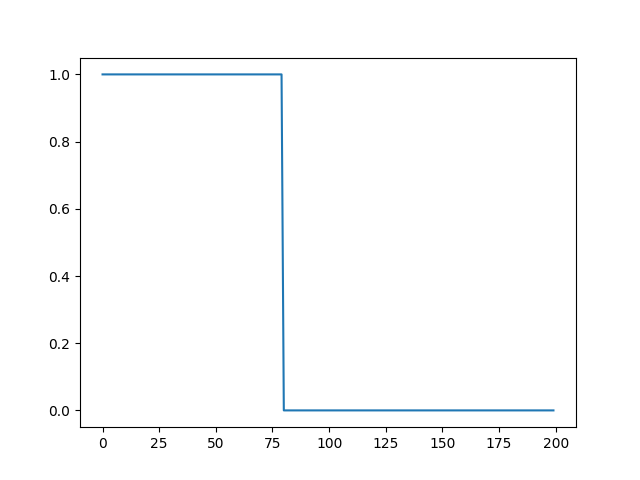

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [3]:
env = Env(200)

num_states = 200*2 #space x direction
num_actions = 2


alpha = 0.1
gamma = 0.9


#Q = np.random.random((num_states, num_actions))
Q = np.zeros((num_states, num_actions))

Q[:80,0]=0      
Q[:80,1]=1000

Q[80:200,0]=1000
Q[80:200,1]=0

Q[200:320,0]=0
Q[200:320,1]=1000

Q[320:,0]=1000
Q[320:,1]=0

pleft = np.argmax(Q[:200,:], axis=1)
plt.plot(pleft)
plt.show()
pleft

In [8]:
epsilon = 0.1
num_episodes = 1000000
env.init_canvas()
for i_episode in tqdm(range(num_episodes), desc='episode'):
    obs = env.reset()
    state = obs[0] if obs[1]==-1 else obs[0]+100 #encode observation to look-up state in Q table
    terminated = False
    while not terminated:
        
        #choose action
        if random.uniform(0,1)<epsilon:
            action = random.randrange(0, num_actions)
        else:
            action = np.argmax(Q[state])
    
        #apply action
        next_obs, reward, terminated = env.step(action)
        next_state = next_obs[0] if next_obs[1]==-1 else next_obs[0]+100
        
        #update q-value function
        td_target = reward + gamma * np.argmax(Q[next_state])
        td_error = td_target - Q[state,action]
        Q[state,action] += alpha * td_error
        
        obs = next_obs
        
        
        #env.update_canvas(sleeptime=0.02)   
        if i_episode % 1000==0:
            env.update_canvas(sleeptime=0.02)        



RoughCanvas(height=200, width=500)

episode: 100%|████████████████████████████████████████████████████████████| 1000000/1000000 [12:54:45<00:00, 21.51it/s]


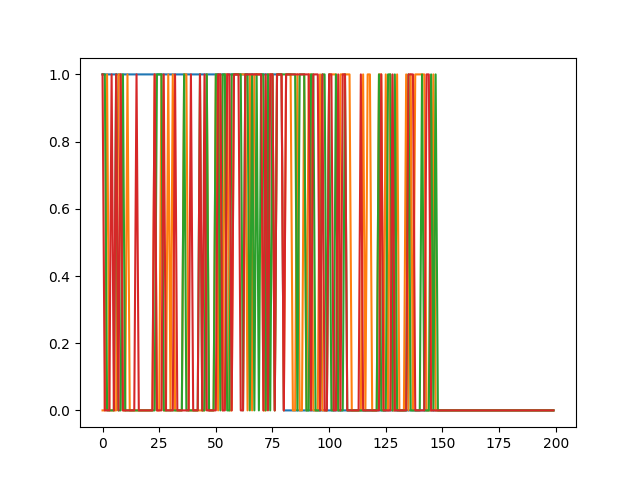

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [9]:
pleft = np.argmax(Q[:200,:], axis=1)
plt.plot(pleft)
plt.show()
pleft

In [ ]:
def create_rl_model(n_actions):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=n_actions, activation=None)  #returns logits (un-normalized log-proba for each action)
    ])
    return model

#a logbook to remember observations, actions and rewards for an entire episode
class Memory:
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.observations=[]
        self.actions=[]
        self.rewards=[]
        
    def add_to_memory(self, new_obs, new_action, new_reward):
        self.observations.append(new_obs)
        self.actions.append(new_action)
        self.rewards.append(new_reward)
        
    def __len__(self):
        return len(self.actions)

def choose_action(model, observation, single=True, greedy=False):

    # add batch dimension to the observation if only a single example was provided
    observation = np.expand_dims(observation, axis=0) if single else observation
    logits = model.predict(observation, verbose=0)
    
    if greedy:
        opt = np.argmax(logits, axis=-1)
        return (opt[0], logits[0]) if single else (opt, logits)
    else:
        action = tf.random.categorical(logits, num_samples=1)  #randomly pick an action - tf's categorical takes unornmalized log proba as input
        action = action.numpy().flatten()
        return action[0] if single else action

def normalize(x):
    x -= np.mean(x)
    s = np.std(x)
    if s:
        x /= np.std(x)
    return x.astype(np.float32)

def discount_rewards(rewards, gamma=0.95):
    discounted_rewards = np.zeros_like(rewards)
    R=0
    for t in reversed(range(0, len(rewards))):
        R = R*gamma + rewards[t]
        discounted_rewards[t]=R
    return normalize(discounted_rewards)

def compute_loss(logits, actions, rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    loss = tf.reduce_mean(neg_logprob*rewards)
    return loss

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards):

    with tf.GradientTape() as tape:
        prediction = model(observations)
        loss = loss_function(prediction, actions, discounted_rewards)
    
    grads = tape.gradient(loss, model.trainable_variables)
    
    grads, _ = tf.clip_by_global_norm(grads, 2.0)
    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [34]:
28*3600

100800

In [ ]:

env = Env(200) #each episode lasts 100 time steps
model = create_rl_model(n_actions=2)
env.obs()
res = env.play(model)

In [ ]:
memory = Memory()
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
obs = env.reset()
memory.clear()
terminated = False
while not terminated:
    action = choose_action(model, obs)
    next_obs, reward, terminated = env.step(action)
    memory.add_to_memory(obs, action, reward)
    obs = next_obs

In [ ]:
discounted_rewards = discount_rewards(memory.rewards)
observations=np.vstack(memory.observations)
actions=np.array(memory.actions)

In [ ]:
#observations


In [ ]:
with tf.GradientTape() as tape:
    predictions = model(observations)
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predictions, labels=memory.actions)
    loss = tf.reduce_mean(neg_logprob*discounted_rewards)
    
grads = tape.gradient(loss, model.trainable_variables)

In [ ]:
#model.get_weights()

In [ ]:
old_weights = model.get_weights()

grads, _ = tf.clip_by_global_norm(grads, 2.0)
optimizer.apply_gradients(zip(grads, model.trainable_variables))

weights = model.get_weights()

In [ ]:
weights[0] - old_weights[0]

In [ ]:
%matplotlib inline

memory = Memory()

learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_episodes=100

fig, (ax1, ax2) = pl.subplots(1,2)
losses=[]
scores=[]
start = time.time()

for i_episode in range(num_episodes):
    obs = env.reset()
    memory.clear()
    terminated = False
    
    #run the episode, keeping the model constant
    while not terminated:
        action = choose_action(model, obs)
        next_obs, reward, terminated = env.step(action)
        memory.add_to_memory(obs, action, reward)
        obs = next_obs

    score = reward
    
    loss = train_step(model, compute_loss, optimizer, 
               observations=np.vstack(memory.observations),
               actions=np.array(memory.actions),
               discounted_rewards = discount_rewards(memory.rewards))
    
    end = time.time()
    
    scores.append(score)
    losses.append(loss)
    ax1.plot(scores,"b+-")
    ax2.plot(losses,"g+-")
    #ax1.scatter(i_episode,score, c='blue')
    #ax2.scatter(i_episode,loss, c='black')
    ipd.display(pl.gcf())   #ipd is IPython's display module
    ipd.clear_output(wait=True)
    
    #print(i_episode, "score:", score, "loss:", loss.numpy(), "time remaining:", (num_episodes-i_episode+1)*(end-start)/(i_episode+1)/60)


In [ ]:
model_file = 'rl_'+time.strftime("%Y%m%d-%H%M%S")
print(model_file)
model.save(model_file)

In [ ]:
env = Env(500)
print(env.obs())
res = env.play(model)


In [ ]:
res[0][2]

In [ ]:
for i,r in enumerate(res):
    
    x=res[i][0][0]
    speed=res[i][0][1]
    logits=res[i][1]
    action=res[i][2]
    reward=res[i][3]
    print(i, "\t\tobs:%d"%x, "\t\tspeed:%d"%speed,"\tlogits:",logits, "\taction:%d"%action, "\trwd:%d"%reward)

In [ ]:
fig, (ax1, ax2) = pl.subplots(1,2)

rangex = 100
stepx = 10
xs = np.ones((int(2*rangex/stepx),2)) #2 obs
xs[:,0] = np.arange(-rangex,+rangex, stepx)

xs[:,1] *= 1
p = tf.nn.softmax(model.predict(xs))

pp = p[:,0] - p[:,1]  #certainty = proba class 0 - proba class 1
ax1.plot(xs[:,0], p[:,0], 'g')
ax1.plot(xs[:,0], p[:,1], 'r')
#ax1.plot(xs[:,0], pp, c='blue')

xs[:,1] *= -1
p = tf.nn.softmax(model.predict(xs))
pp = p[:,0] - p[:,1]  #certainty = proba class 0 - proba class 1
#ax1.plot(xs[:,0], pp, c='green')
ax2.plot(xs[:,0], p[:,0], 'g')
ax2.plot(xs[:,0], p[:,1], 'r')



In [ ]:
gl